<a href="https://colab.research.google.com/github/shreya4607/Training-an-image-classifier-CIFAR10/blob/main/Training%20an%20image%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:10<00:00, 16.1MB/s]


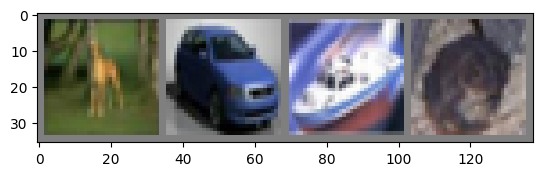

dog   car   ship  frog 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.154
[1,  4000] loss: 1.859
[1,  6000] loss: 1.664
[1,  8000] loss: 1.556
[1, 10000] loss: 1.513
[1, 12000] loss: 1.462
[2,  2000] loss: 1.373
[2,  4000] loss: 1.361
[2,  6000] loss: 1.330
[2,  8000] loss: 1.312
[2, 10000] loss: 1.289
[2, 12000] loss: 1.289
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

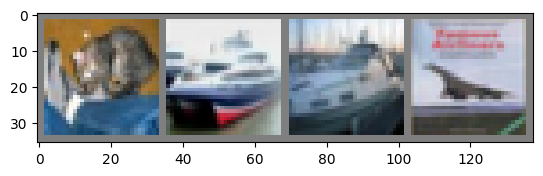

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.0 %
Accuracy for class: car   is 83.0 %
Accuracy for class: bird  is 35.9 %
Accuracy for class: cat   is 34.1 %
Accuracy for class: deer  is 34.9 %
Accuracy for class: dog   is 46.7 %
Accuracy for class: frog  is 74.4 %
Accuracy for class: horse is 49.9 %
Accuracy for class: ship  is 68.0 %
Accuracy for class: truck is 55.5 %


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [16]:
from sklearn.metrics import precision_recall_fscore_support

all_preds = []
all_labels = []

# Collect all predictions and true labels
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(classes)))

# Display metrics per class
for i, classname in enumerate(classes):
    print(f"{classname:5s} | Precision: {precision[i]:.2f} | Recall: {recall[i]:.2f} | F1-score: {f1[i]:.2f}")

plane | Precision: 0.56 | Recall: 0.65 | F1-score: 0.60
car   | Precision: 0.53 | Recall: 0.83 | F1-score: 0.65
bird  | Precision: 0.49 | Recall: 0.36 | F1-score: 0.41
cat   | Precision: 0.42 | Recall: 0.34 | F1-score: 0.38
deer  | Precision: 0.52 | Recall: 0.35 | F1-score: 0.42
dog   | Precision: 0.52 | Recall: 0.47 | F1-score: 0.49
frog  | Precision: 0.52 | Recall: 0.74 | F1-score: 0.61
horse | Precision: 0.73 | Recall: 0.50 | F1-score: 0.59
ship  | Precision: 0.67 | Recall: 0.68 | F1-score: 0.67
truck | Precision: 0.54 | Recall: 0.56 | F1-score: 0.55


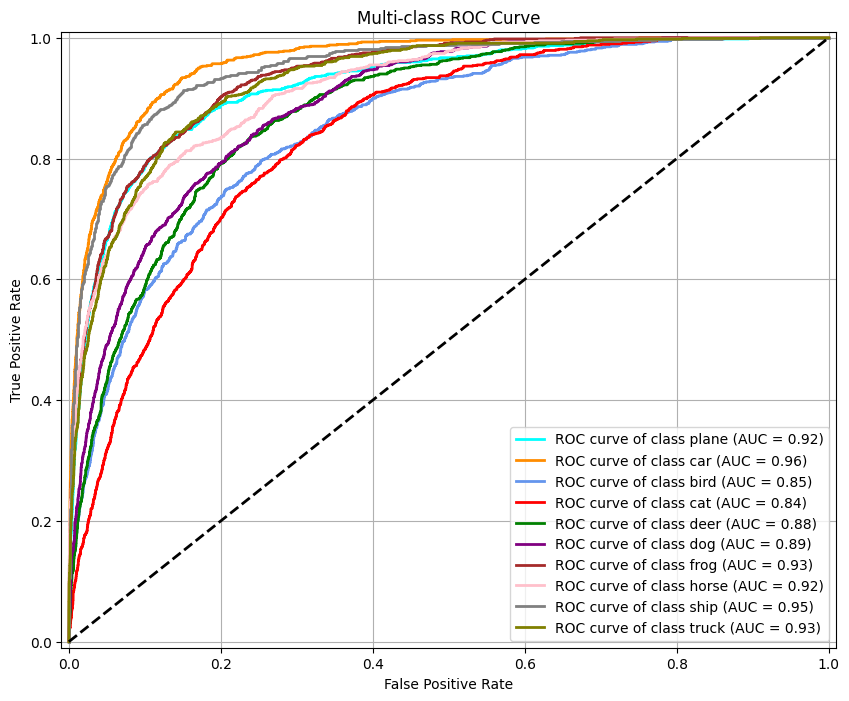

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Binarize labels (One-vs-Rest format)
n_classes = len(classes)
all_probs = []
all_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_true.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_true = np.hstack(all_true)
binary_labels = label_binarize(all_true, classes=list(range(n_classes)))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()